In [165]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [166]:
import pandas as pd
import numpy as np
import scipy.stats as sp_stats
import requests
from datetime import timedelta
import matplotlib.pyplot as plt

In [167]:
class CusumTest:
    """ Chu-Stinchcombe-White CUSUM Test on Levels
    Implements a hypothesis test where the null-hypothesis is that the
    timeseries does not change.  For each bar we compute the test statistic
    (and 95% threshold) for multiple backward windows up to ticks_required
    away.  We take the max over all these stats to compute our filter value.
    Ref: de Prado Section 17.3.2
    """
    def __init__(self, ticks_required, **kwargs):
        self.ticks_required = ticks_required
        # out name should uniquely identify the feature with all its args
        self.output_column_names = []
        for ticks in ticks_required:
            self.output_column_names.append('{0}_cusum_test'.format(ticks))
            
        self.critical_value = 0

        def compute_stat(x, n_tick, thresholds):
            """
            Computes the max S_n_t for all n inside the window.
            """
            var = np.square(np.diff(x)).mean()
            if np.isnan(var) or var < 1e-7:
                return 0.0

            x_slice = x[-2::-1]
            result = (x[-1] - x_slice) / np.sqrt(var * n_tick)
            result -= thresholds
            result = result.max()

            return float(result > 0)

        self.compute_stat = compute_stat


    def generate_bulk(self, reg_ticks: pd.DataFrame):
        log_prices = np.log(reg_ticks['close'])
        cusum_test_stats = []
        for ticks in self.ticks_required:
            rolling = log_prices.rolling(
                ticks, min_periods=ticks)
            n_tick = range(1, ticks)
            thresholds = np.sqrt(4.6 + np.log(n_tick))
            cusum_test_stat = (rolling.apply(lambda x: self.compute_stat(x, n_tick, thresholds), raw=True).values).astype(np.float)
            cusum_test_stats.append(cusum_test_stat)

        cusum_test_stats = np.array(cusum_test_stats)
        return pd.DataFrame(index=reg_ticks.index,
                            data=cusum_test_stats.transpose(),
                            columns=self.output_column_names)
    
    def generate_bulk_log_volume(self, reg_ticks: pd.DataFrame):
        log_prices = np.log(reg_ticks['close'])
        log_volume = np.log(reg_ticks['volume']).tolist()
        cusum_test_stats = []
        for max_ticks in self.ticks_required:
            cusum_test_stat = []
            for i in range(0,len(log_volume)):
                ticks = int(max_ticks / log_volume[i])
                if (ticks < 1):
                    ticks = 0
                n_tick = range(1, ticks)
                thresholds = np.sqrt(4.6 + np.log(n_tick))
                rolling = log_prices.rolling(ticks, min_periods=ticks)
                stats = (rolling.apply(lambda x: self.compute_stat(x, n_tick, thresholds), raw=True).values).astype(np.float)                
                cusum_test_stat.append(stats[i])
            cusum_test_stats.append(cusum_test_stat)

        cusum_test_stats = np.array(cusum_test_stats)
        return pd.DataFrame(index=reg_ticks.index,
                            data=cusum_test_stats.transpose(),
                            columns=self.output_column_names)


In [168]:
class StructuralBreakFeatures:
    DEFAULT_FEATURES_TO_CALCULATE = []
    DROP_COLUMNS = ['open', 'high', 'low']

    def __init__(self,
                 features_to_calculate=None,
                 interval_size: timedelta=timedelta(days=1),
                 drop_columns=None):
        if features_to_calculate is None:
            features_to_calculate = self.DEFAULT_FEATURES_TO_CALCULATE

        if drop_columns is None:
            drop_columns = self.DROP_COLUMNS

        # Create feature generator and compute features
        self.interval_type = 'time'
        self.interval_size = interval_size
        self.features_to_calculate = features_to_calculate
        self.drop_columns = drop_columns

    def get_feature_data(self, data_df):
        """ Compute all features.
        :param data_df:
        :return:
        """
        feature_generator = CusumTest(self.features_to_calculate)
        data_df_enriched = data_df.join(feature_generator.generate_bulk(data_df))
#         data_df_enriched = data_df_enriched.drop(self.DROP_COLUMNS, axis=1)

        return data_df_enriched

    def get_feature_data_log_volume(self, data_df):
        """ Compute all features.
        :param data_df:
        :return:
        """
        feature_generator = CusumTest(self.features_to_calculate)
        data_df = data_df[data_df['close'] != 0]
        data_df = data_df[data_df['volume'] != 0]
        data_df_enriched = data_df.join(feature_generator.generate_bulk_log_volume(data_df))
#         data_df_enriched = data_df_enriched.drop(self.DROP_COLUMNS, axis=1)

        return data_df_enriched

In [169]:

POLONIEX_OHLCV_BASEURL = 'https://poloniex.com/public?command=returnChartData&currencyPair='

"""
https://poloniex.com/public?command=returnChartData&currencyPair=BTC_POT&start=1435699200&end=9999999999&period=14400

"""

def get_ohlcv_poloniex(pair='BTC_ETH', start=1435699200, end=9999999999, period=900):
    """
    returns ohlcv data for poloniex as pandas dataframe
    convert to unix timestamp using https://coderstoolbox.net/unixtimestamp/
    :param pair: str pair on poloniex
    :param start: int unix timestamp of beginning time
    :param end: int unix timestamp of ending time
    :param period: int candle width in seconds
    :return: pandas df of ohlcv data from poloniex for specified pair, times, and period
    """
    query = POLONIEX_OHLCV_BASEURL + pair + '&start=' + str(start) + '&end=' + str(end) + '&period=' + str(period)
    resp = requests.get(query)

    if resp.status_code != 200:
        raise requests.ApiError('GET /tasks/ {}'.format(resp.status_code))

    return pd.DataFrame(resp.json())

In [170]:
df = get_ohlcv_poloniex(pair='USDT_BTC', start=0, end=9999999999, period=86400)

In [171]:
df.head()

,close,date,high,low,open,quoteVolume,volume,weightedAverage
0,244.00,1424304000,0.330,225.00,0.330000,0.193117,46.276313,239.627778
1,240.25,1424390400,245.000,240.25,240.250118,0.230429,55.894897,242.568479
2,245.00,1424476800,245.000,245.00,245.000000,0.060091,14.722239,245.000000
3,235.00,1424563200,249.000,235.00,245.000000,0.539055,129.121248,239.532608
4,235.00,1424649600,235.001,235.00,235.000002,0.410926,96.567562,235.000062


In [172]:
df['time'] = pd.to_datetime(df['date'], unit='s')
df.index = df['time']
df.head()

,close,date,high,low,open,quoteVolume,volume,weightedAverage,time
time,,,,,,,,,
2015-02-19,244.00,1424304000,0.330,225.00,0.330000,0.193117,46.276313,239.627778,2015-02-19
2015-02-20,240.25,1424390400,245.000,240.25,240.250118,0.230429,55.894897,242.568479,2015-02-20
2015-02-21,245.00,1424476800,245.000,245.00,245.000000,0.060091,14.722239,245.000000,2015-02-21
2015-02-22,235.00,1424563200,249.000,235.00,245.000000,0.539055,129.121248,239.532608,2015-02-22
2015-02-23,235.00,1424649600,235.001,235.00,235.000002,0.410926,96.567562,235.000062,2015-02-23


In [173]:
df_prices = df[['close', 'high', 'low', 'open', 'weightedAverage']]
df_volume = (df[['quoteVolume', 'volume']] + 0.001)
log_df = np.log(pd.concat([df_prices, df_volume], axis=1))
log_df.head()

,close,high,low,open,weightedAverage,quoteVolume,volume
time,,,,,,,
2015-02-19,5.497168,-1.108663,5.416100,-1.108663,5.479087,-1.639292,3.834652
2015-02-20,5.481680,5.501258,5.481680,5.481681,5.491284,-1.463481,4.023491
2015-02-21,5.501258,5.501258,5.501258,5.501258,5.501258,-2.795394,2.689427
2015-02-22,5.459586,5.517453,5.459586,5.501258,5.478690,-0.616084,4.860760
2015-02-23,5.459586,5.459590,5.459586,5.459586,5.459586,-0.886912,4.570253


In [174]:
df_daily = df#.resample('D').mean()
df_log_daily = log_df#.resample('D').mean()
# re-add time column - needed for feature generation
df_daily['time'] = pd.to_datetime(df_daily.index)
df_log_daily['time'] = pd.to_datetime(df_log_daily.index)

In [175]:
df_daily.head()

,close,date,high,low,open,quoteVolume,volume,weightedAverage,time
time,,,,,,,,,
2015-02-19,244.00,1424304000,0.330,225.00,0.330000,0.193117,46.276313,239.627778,2015-02-19
2015-02-20,240.25,1424390400,245.000,240.25,240.250118,0.230429,55.894897,242.568479,2015-02-20
2015-02-21,245.00,1424476800,245.000,245.00,245.000000,0.060091,14.722239,245.000000,2015-02-21
2015-02-22,235.00,1424563200,249.000,235.00,245.000000,0.539055,129.121248,239.532608,2015-02-22
2015-02-23,235.00,1424649600,235.001,235.00,235.000002,0.410926,96.567562,235.000062,2015-02-23


In [176]:
df_log_daily.head()

,close,high,low,open,weightedAverage,quoteVolume,volume,time
time,,,,,,,,
2015-02-19,5.497168,-1.108663,5.416100,-1.108663,5.479087,-1.639292,3.834652,2015-02-19
2015-02-20,5.481680,5.501258,5.481680,5.481681,5.491284,-1.463481,4.023491,2015-02-20
2015-02-21,5.501258,5.501258,5.501258,5.501258,5.501258,-2.795394,2.689427,2015-02-21
2015-02-22,5.459586,5.517453,5.459586,5.501258,5.478690,-0.616084,4.860760,2015-02-22
2015-02-23,5.459586,5.459590,5.459586,5.459586,5.459586,-0.886912,4.570253,2015-02-23


In [177]:
features = [10, 20, 30, 50, 75, 100, 150, 200, 250, 300, 350, 400, 450, 500, 600, 700, 800]
cusum_features = StructuralBreakFeatures(
    features_to_calculate=features
)
enriched_cusum = cusum_features.get_feature_data(df_daily)
enriched_cusum.tail()

,close,date,high,low,open,quoteVolume,volume,weightedAverage,time,10_cusum_test,...,200_cusum_test,250_cusum_test,300_cusum_test,350_cusum_test,400_cusum_test,450_cusum_test,500_cusum_test,600_cusum_test,700_cusum_test,800_cusum_test
time,,,,,,,,,,,,,,,,,,,,,
2018-10-05,6642.911276,1538697600,6688.000000,6551.769691,6600.548359,398.291505,2.637212e+06,6621.310567,2018-10-05,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-10-06,6600.179058,1538784000,6647.586482,6570.000000,6636.891919,276.318703,1.825159e+06,6605.268586,2018-10-06,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-10-07,6607.938895,1538870400,6638.961011,6540.000000,6599.502693,307.943289,2.025976e+06,6579.055020,2018-10-07,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-10-08,6674.063726,1538956800,6716.000000,6589.841050,6607.938895,378.845750,2.521344e+06,6655.331202,2018-10-08,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-10-09,6673.764615,1539043200,6678.839554,6653.280900,6674.063726,49.828337,3.321928e+05,6666.744545,2018-10-09,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [178]:
enriched_cusum.describe()

,close,date,high,low,open,quoteVolume,volume,weightedAverage,10_cusum_test,20_cusum_test,...,200_cusum_test,250_cusum_test,300_cusum_test,350_cusum_test,400_cusum_test,450_cusum_test,500_cusum_test,600_cusum_test,700_cusum_test,800_cusum_test
count,1329.000000,1.329000e+03,1329.000000,1329.000000,1329.000000,1329.000000,1.329000e+03,1329.000000,1320.000000,1310.000000,...,1130.000000,1080.000000,1030.000000,980.000000,930.000000,880.000000,830.000000,730.000000,630.000000,530.000000
mean,3064.185803,1.481674e+09,3169.669246,2930.330615,3059.459665,3290.362735,1.589862e+07,3050.583924,0.034091,0.061069,...,0.080531,0.101852,0.137864,0.152041,0.184946,0.228409,0.243373,0.284932,0.304762,0.345283
std,3845.137566,3.315976e+07,4011.632941,3633.954284,3845.313303,5866.451513,3.323362e+07,3820.263628,0.181531,0.239548,...,0.272234,0.302594,0.344925,0.359244,0.388463,0.420046,0.429377,0.451691,0.460672,0.475910
min,178.719313,1.424304e+09,0.330000,99.000000,0.330000,0.000000,0.000000e+00,207.450144,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,409.900000,1.452989e+09,419.989570,399.550000,409.230000,34.854154,1.363318e+04,410.318926,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,777.004279,1.481674e+09,784.785042,767.479122,777.004279,715.841175,8.283338e+05,778.726637,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6218.641536,1.510358e+09,6360.184864,6012.621204,6200.000000,4204.127842,1.739340e+07,6216.814384,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,19223.000000,1.539043e+09,19903.440214,18569.637853,19223.000000,48896.616808,3.960385e+08,19236.130652,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


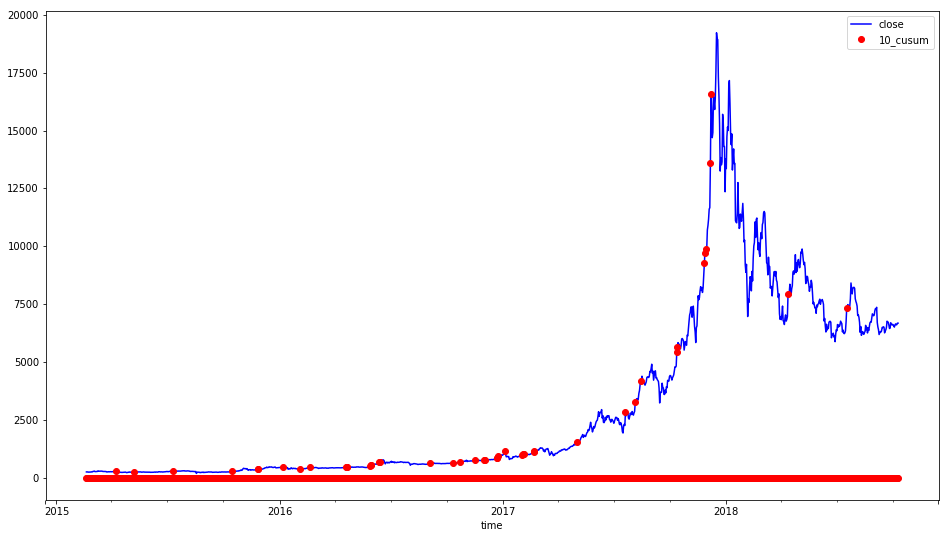

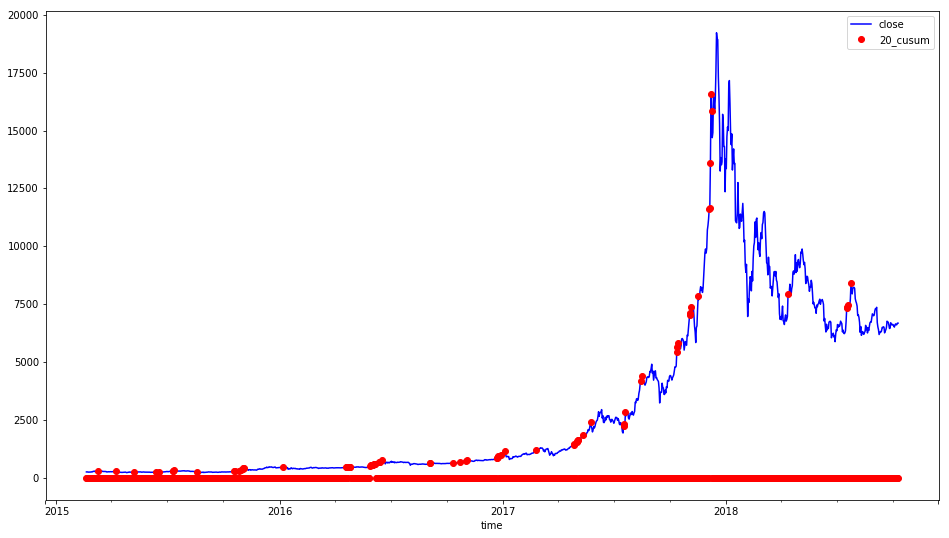

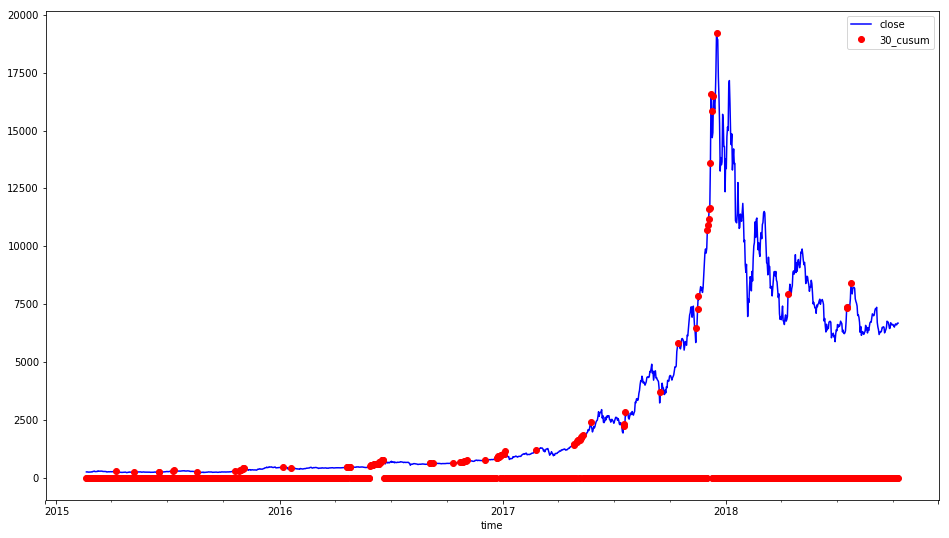

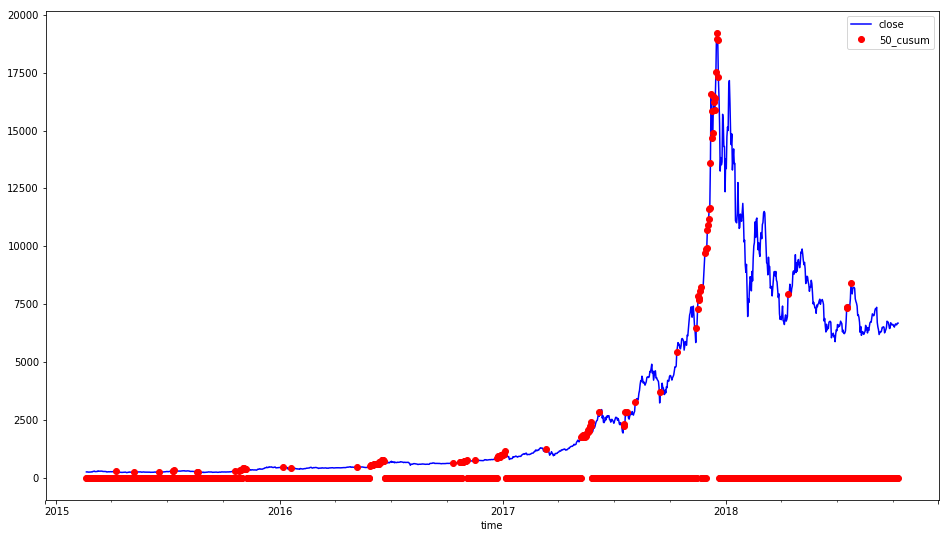

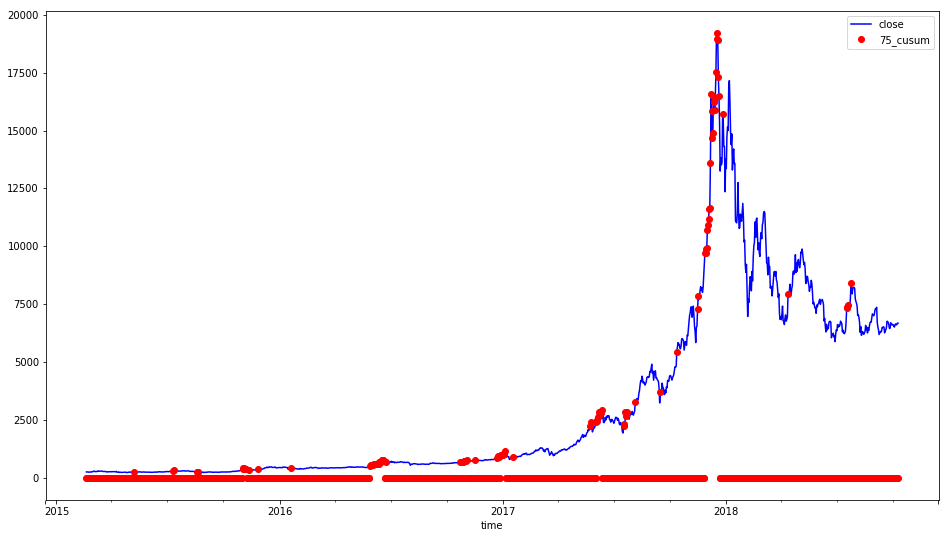

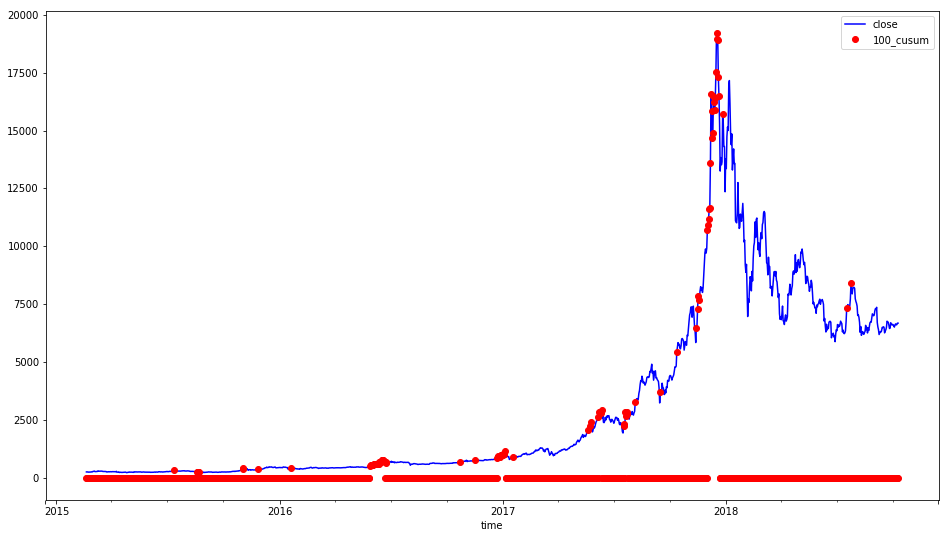

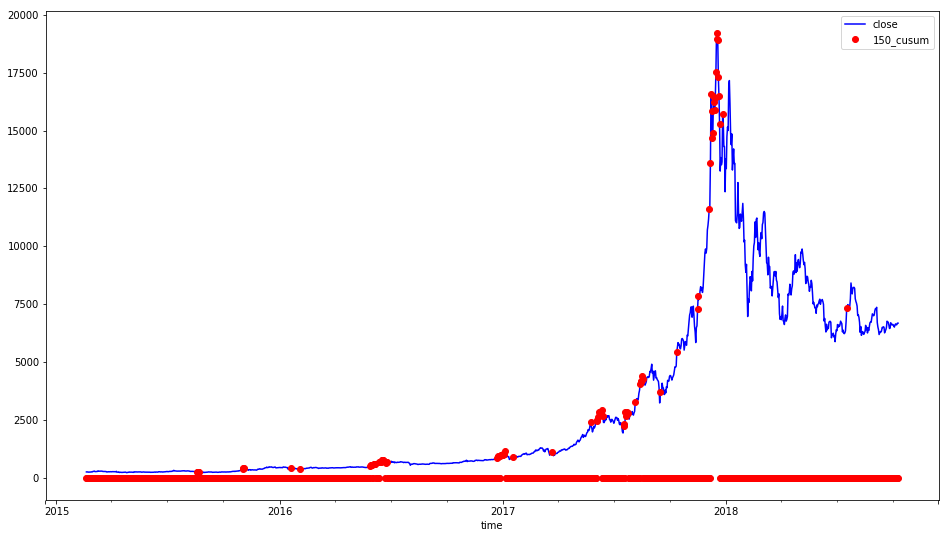

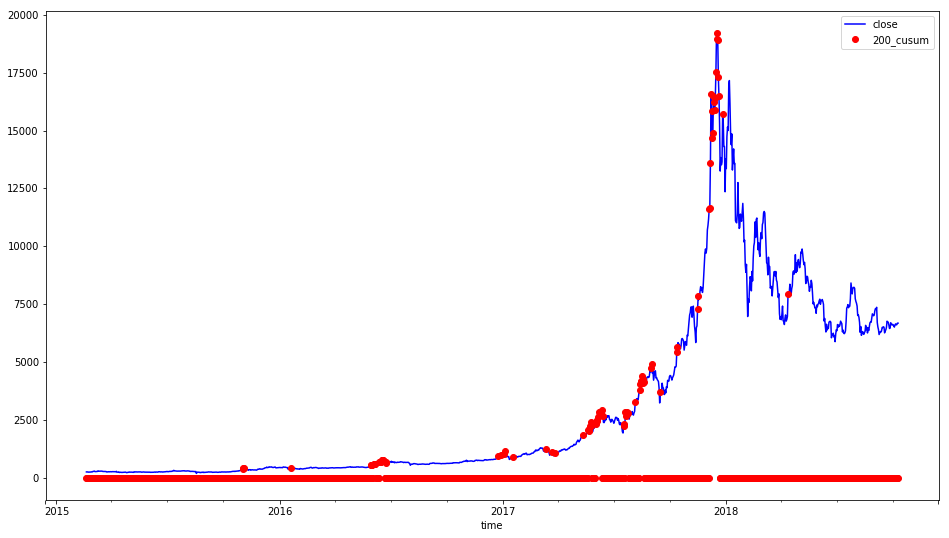

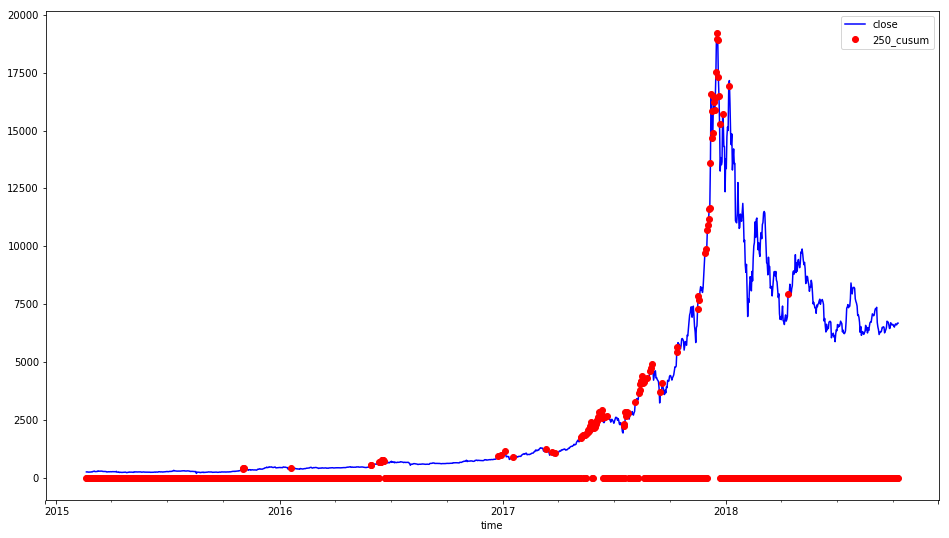

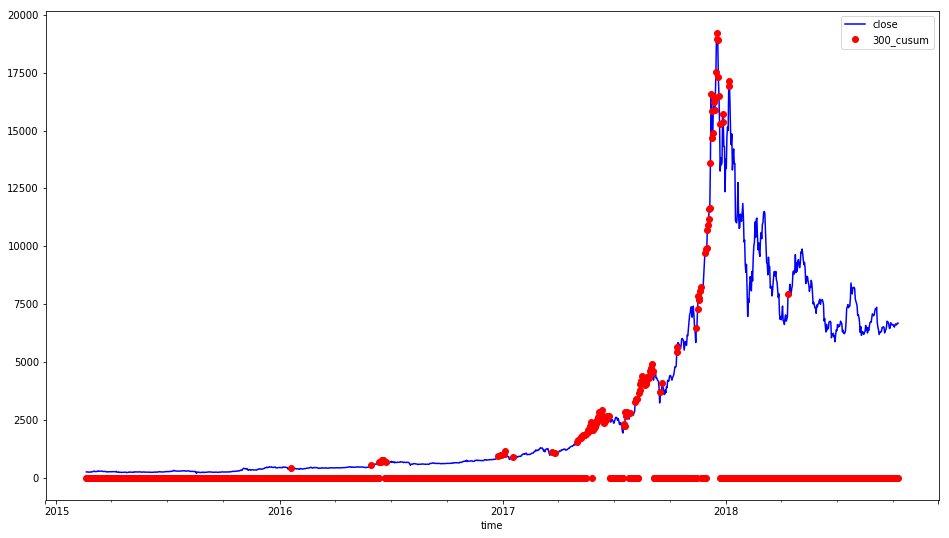

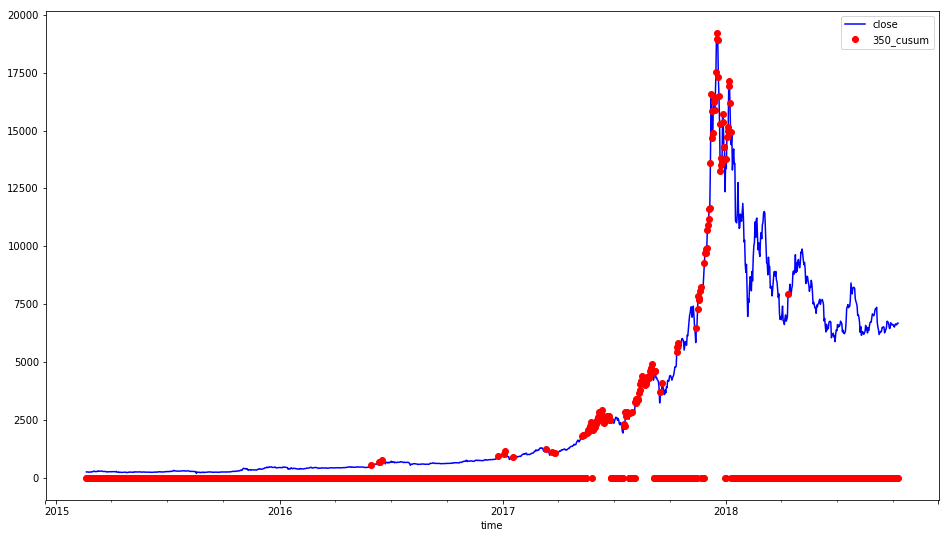

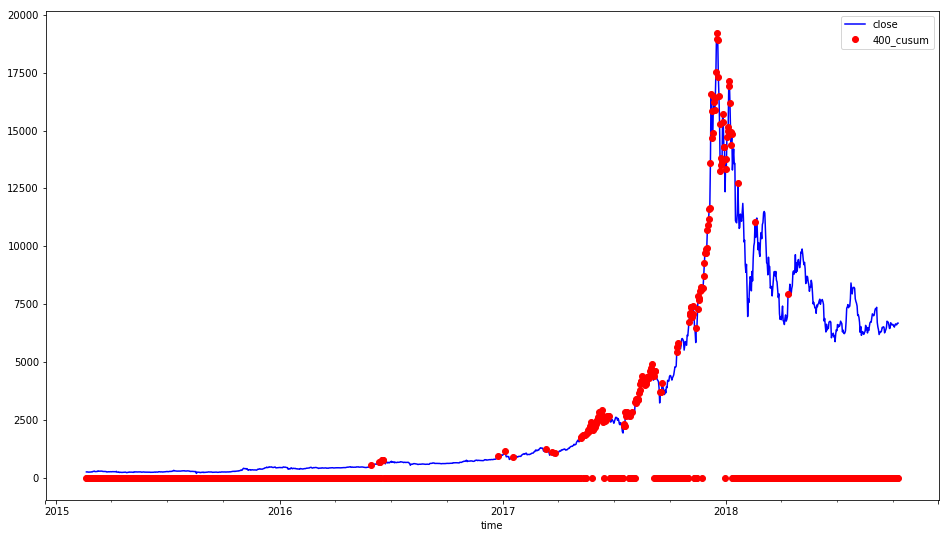

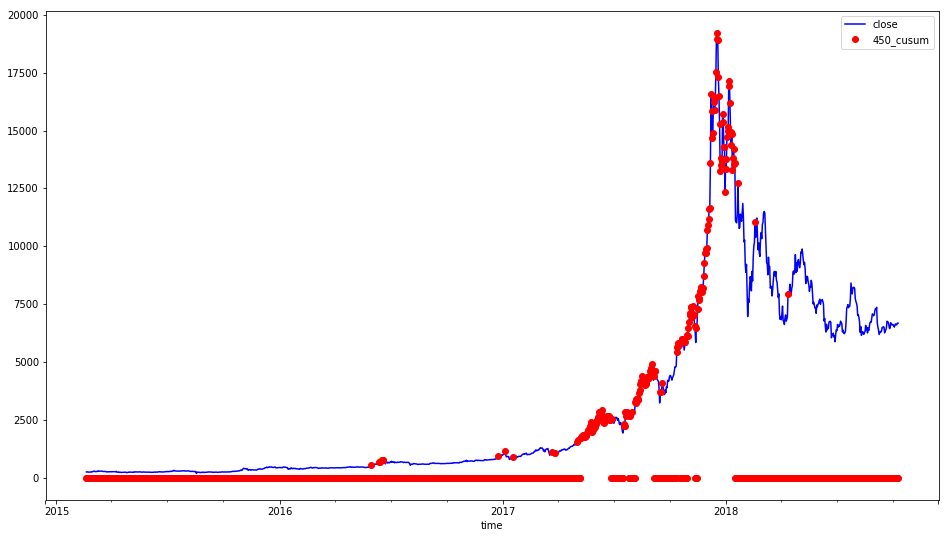

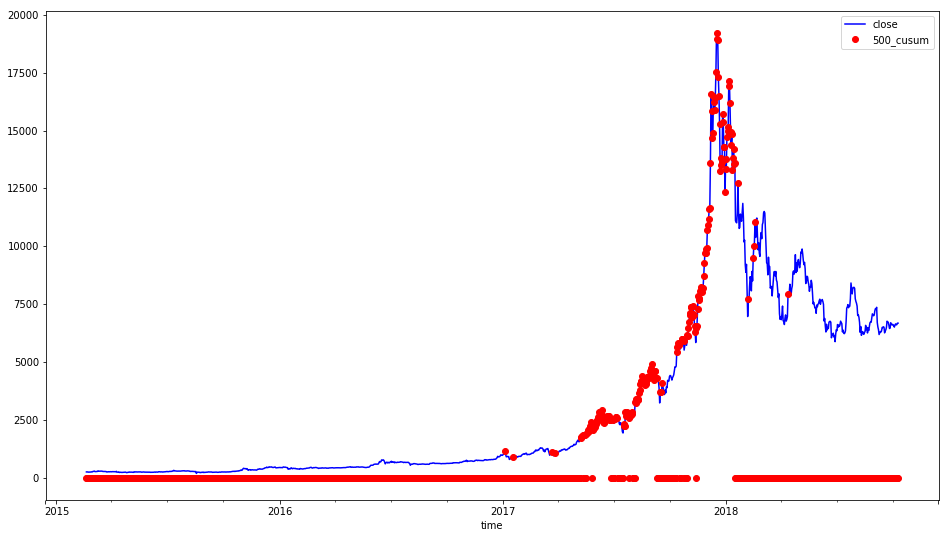

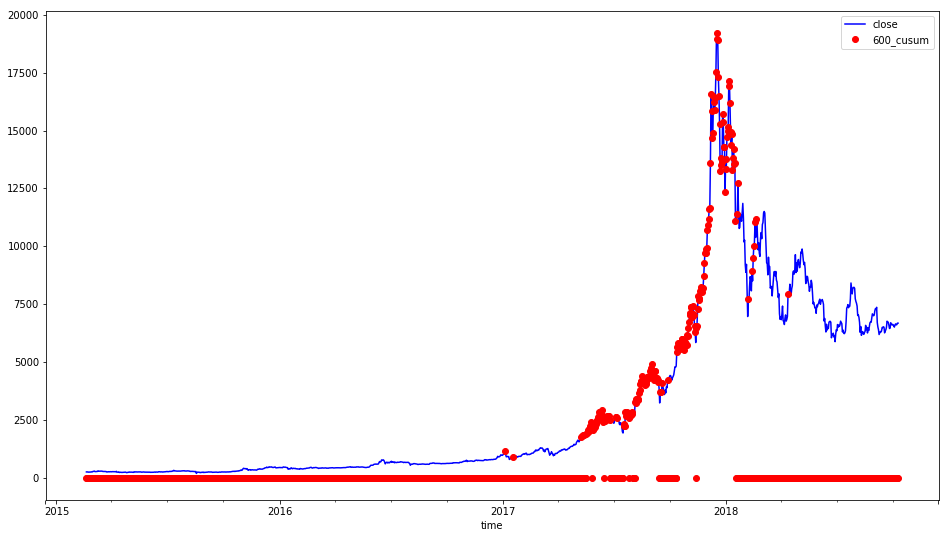

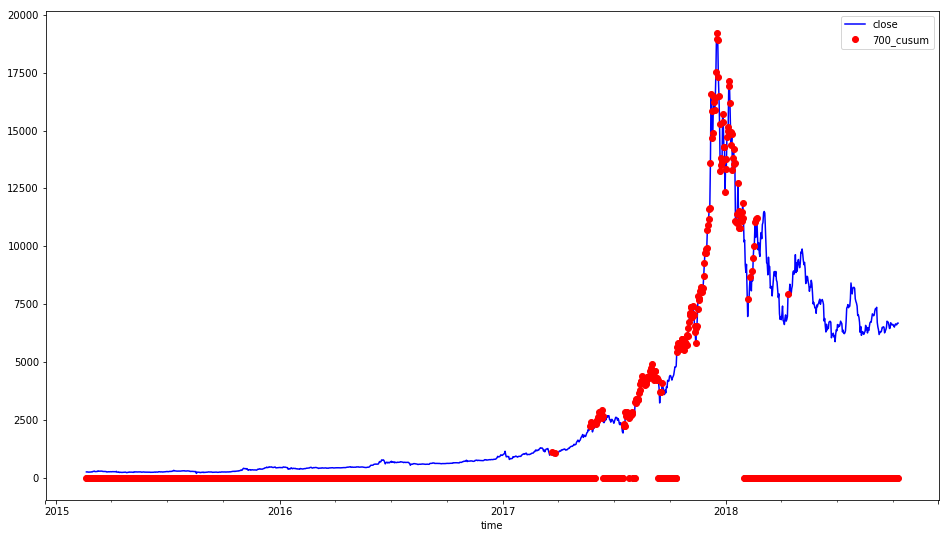

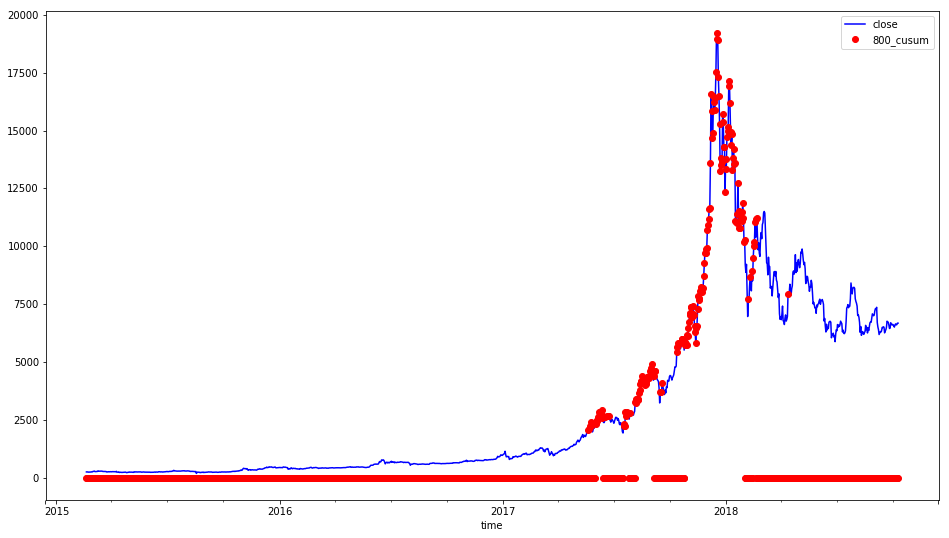

In [179]:
for feature in features:
    fig, ax = plt.subplots(figsize=(16,9))
    cusum = '{0}_cusum'.format(feature)
    cusum_test = '{0}_cusum_test'.format(feature)
    enriched_cusum['close'].plot(ax=ax, style='b-', legend=True)
    enriched_cusum[cusum] = enriched_cusum['close'].where(enriched_cusum[cusum_test] == 1.0, other=0.0)
    enriched_cusum[cusum].plot(ax=ax, style='ro', secondary_y=False, legend=True)

In [180]:
features = [200, 250, 300, 350, 400, 450, 500, 600, 700, 800]
cusum_features = StructuralBreakFeatures(
    features_to_calculate=features
)
enriched_cusum = cusum_features.get_feature_data_log_volume(df_daily)
enriched_cusum.tail()

/Users/robert/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice.


,close,date,high,low,open,quoteVolume,volume,weightedAverage,time,200_cusum_test,250_cusum_test,300_cusum_test,350_cusum_test,400_cusum_test,450_cusum_test,500_cusum_test,600_cusum_test,700_cusum_test,800_cusum_test
time,,,,,,,,,,,,,,,,,,,
2018-10-05,6642.911276,1538697600,6688.000000,6551.769691,6600.548359,398.291505,2.637212e+06,6621.310567,2018-10-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-10-06,6600.179058,1538784000,6647.586482,6570.000000,6636.891919,276.318703,1.825159e+06,6605.268586,2018-10-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-10-07,6607.938895,1538870400,6638.961011,6540.000000,6599.502693,307.943289,2.025976e+06,6579.055020,2018-10-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-10-08,6674.063726,1538956800,6716.000000,6589.841050,6607.938895,378.845750,2.521344e+06,6655.331202,2018-10-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-10-09,6673.764615,1539043200,6678.839554,6653.280900,6674.063726,49.828337,3.321928e+05,6666.744545,2018-10-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [181]:
enriched_cusum.describe()

,close,date,high,low,open,quoteVolume,volume,weightedAverage,200_cusum_test,250_cusum_test,300_cusum_test,350_cusum_test,400_cusum_test,450_cusum_test,500_cusum_test,600_cusum_test,700_cusum_test,800_cusum_test
count,1328.000000,1.328000e+03,1328.000000,1328.000000,1328.000000,1328.000000,1.328000e+03,1328.000000,1279.000000,1267.000000,1259.000000,1246.000000,1239.000000,1226.000000,1221.000000,1214.000000,1203.000000,1189.000000
mean,3066.301382,1.481714e+09,3171.864256,2932.345400,3061.571685,3292.840418,1.591060e+07,3052.689261,0.050821,0.059195,0.065925,0.073034,0.079096,0.082382,0.081900,0.088138,0.094763,0.092515
std,3845.812265,3.313983e+07,4012.345738,3634.580618,3845.990706,5867.965851,3.324328e+07,3820.931441,0.219718,0.236082,0.248250,0.260296,0.269998,0.275058,0.274325,0.283613,0.293009,0.289873
min,178.719313,1.424304e+09,0.330000,99.000000,0.330000,0.000033,9.033750e-03,207.450144,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,409.960000,1.453054e+09,419.997392,399.887500,409.397250,35.909858,1.379017e+04,410.579737,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,778.052140,1.481717e+09,785.747188,768.326615,777.670884,716.872335,8.284700e+05,778.842425,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6218.981152,1.510380e+09,6364.388648,6013.758724,6205.061899,4214.561966,1.740736e+07,6221.186221,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,19223.000000,1.539043e+09,19903.440214,18569.637853,19223.000000,48896.616808,3.960385e+08,19236.130652,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


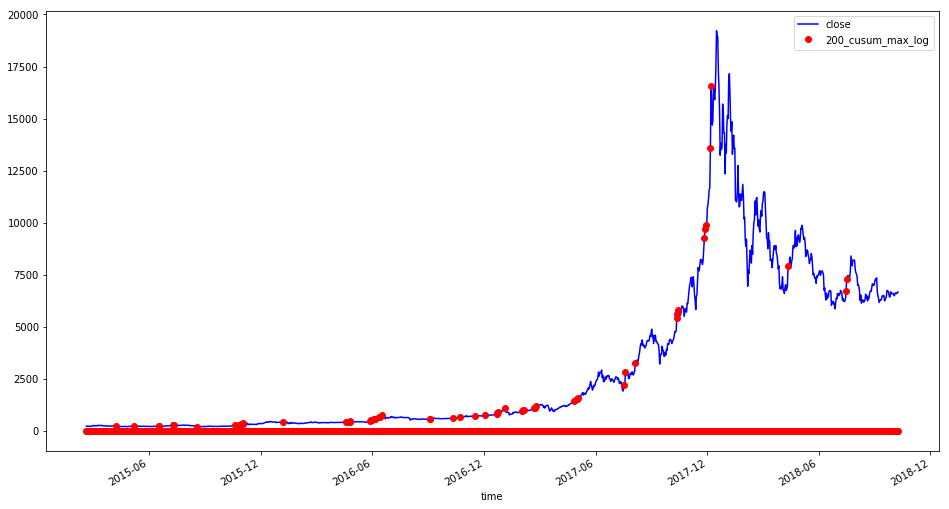

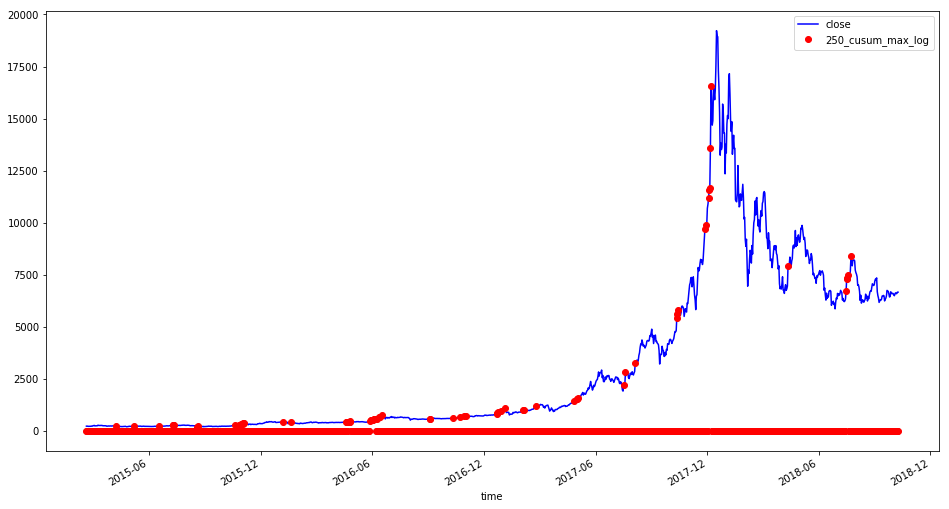

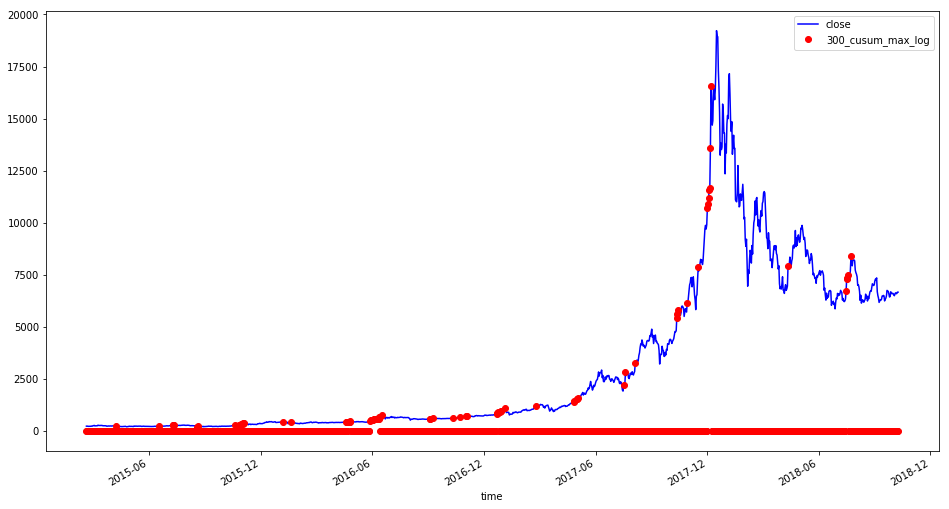

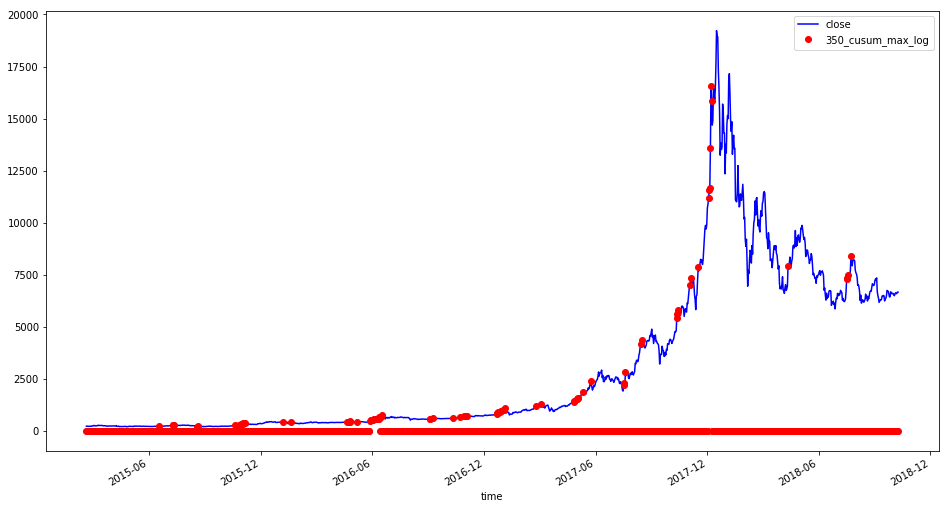

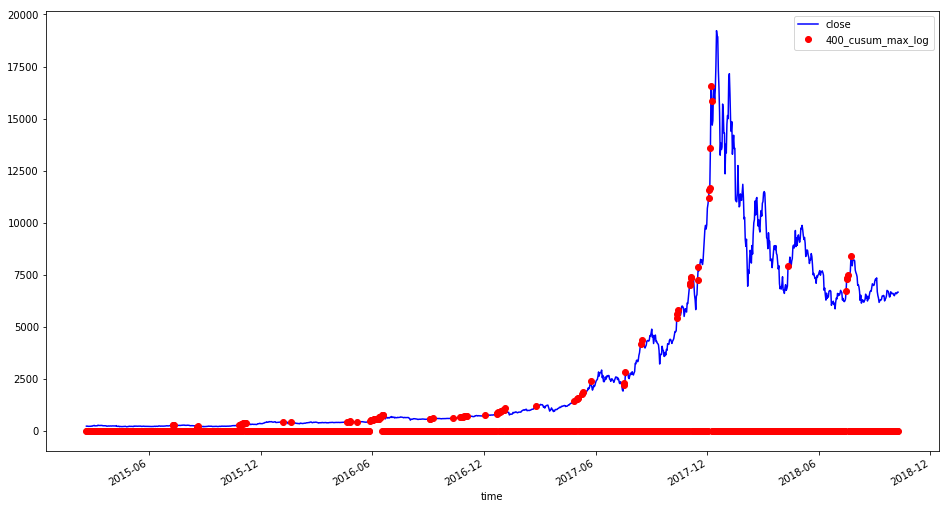

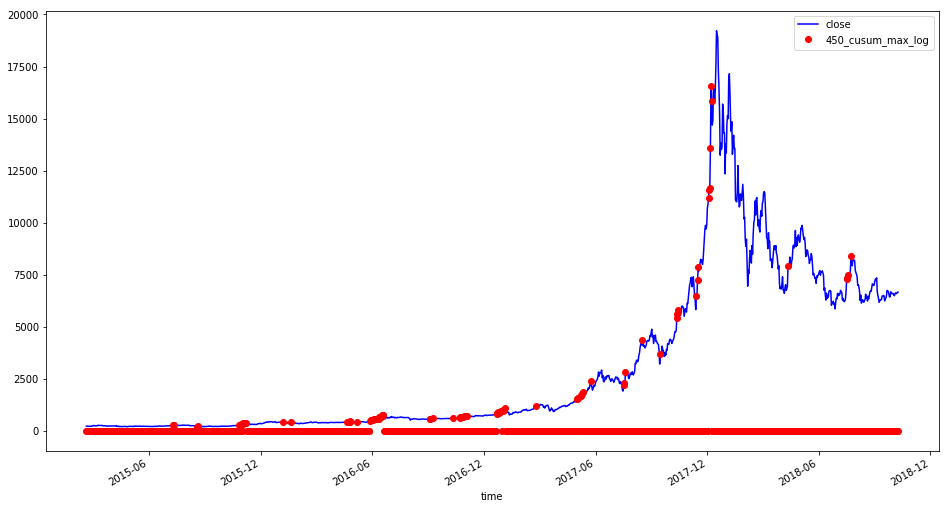

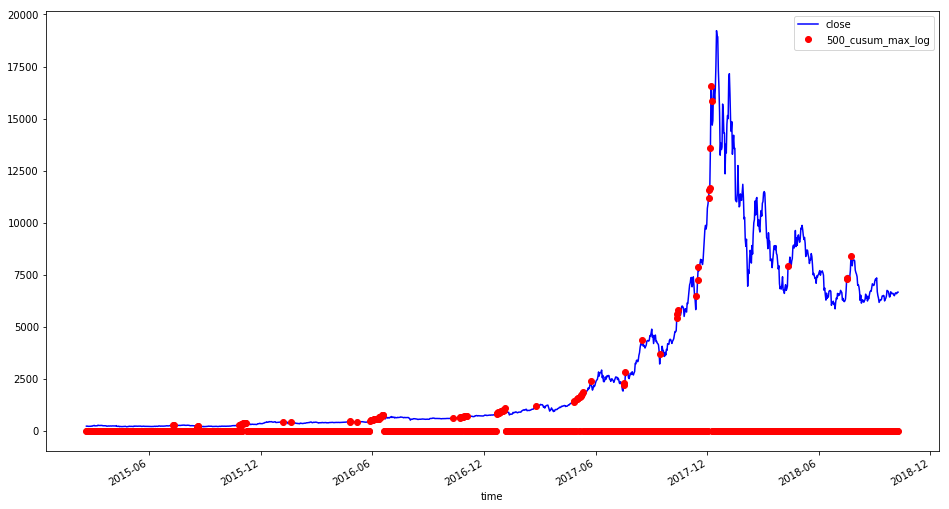

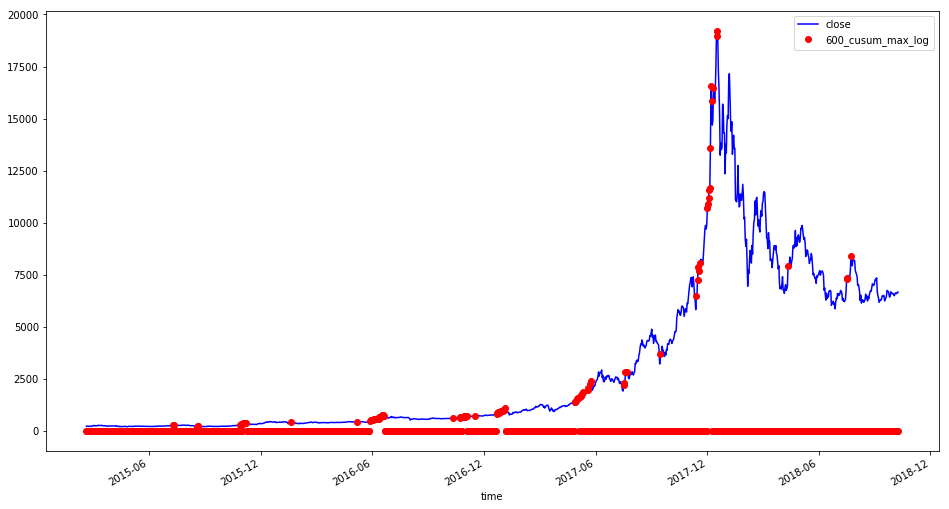

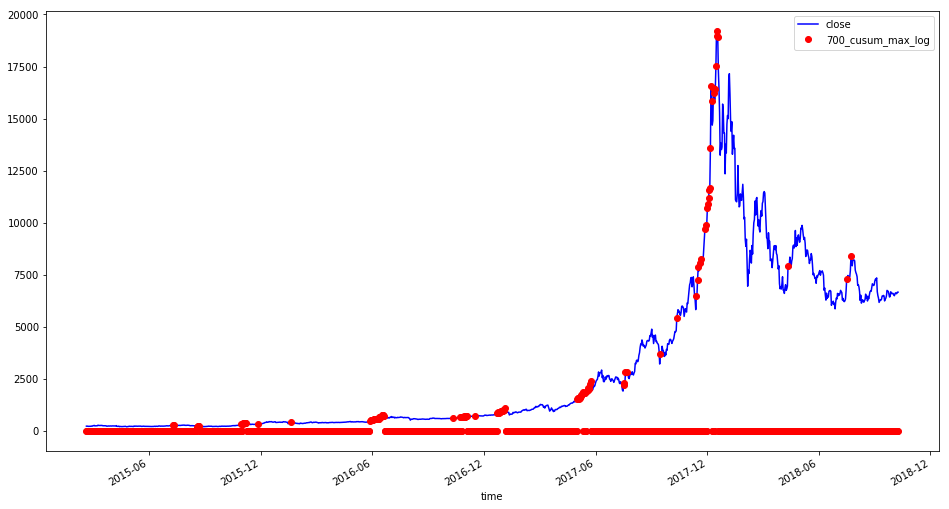

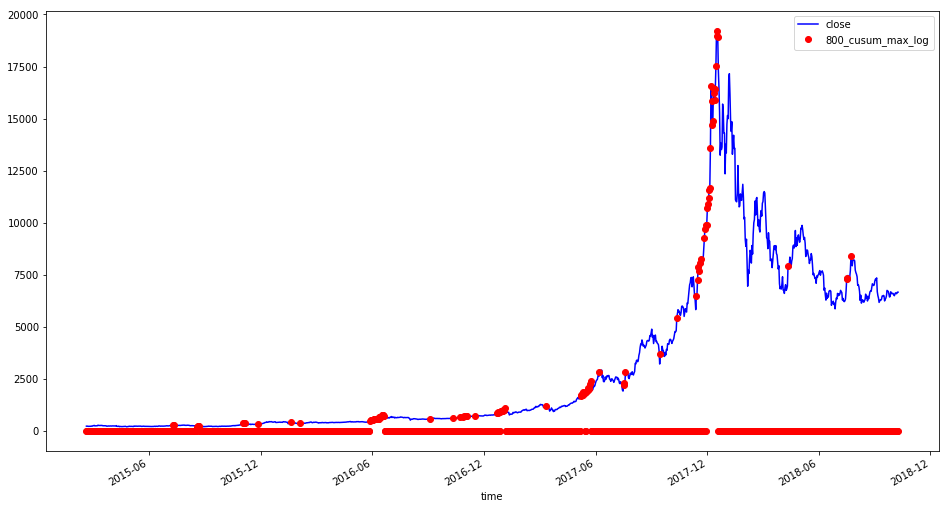

In [182]:
for feature in features:
    fig, ax = plt.subplots(figsize=(16,9))
    cusum = '{0}_cusum_max_log'.format(feature)
    cusum_test = '{0}_cusum_test'.format(feature)
    enriched_cusum['close'].plot(ax=ax, style='b-', legend=True)
    enriched_cusum[cusum] = enriched_cusum['close'].where(enriched_cusum[cusum_test] == 1.0, other=0.0)
    enriched_cusum[cusum].plot(ax=ax, style='ro', secondary_y=False, legend=True)